In [0]:
%matplotlib inline

In [1]:
!pip install -q pyspellchecker

     |████████████████████████████████| 1.9MB 2.8MB/s 


In [0]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

#from spellchecker import SpellChecker

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Bidirectional
from keras.utils import np_utils

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Loading the data

Training data

In [0]:
f = open('/content/drive/My Drive/Projects/Premoji/Data/Train/tweets.txt.text', 'r')
tweets_train = f.readlines()[:50000] # using 10% of the actual data for fast training#
#tweets_train = f.readlines()
f.close()

In [6]:
f = open('/content/drive/My Drive/Projects/Premoji/Data/Train/tweets.txt.labels', 'r')
labels_train = f.readlines()[:50000] # using 10% of the actual data for fast training
#labels_train = f.readlines()
f.close

<function TextIOWrapper.close>

In [0]:
y_train = np_utils.to_categorical([int(l.strip()) for l in labels_train], 20)

Test data

In [0]:
f = open('/content/drive/My Drive/Projects/Premoji/Data/Test/us_test.text', 'r')
tweets_test = f.readlines()
f.close()

In [24]:
f = open('/content/drive/My Drive/Projects/Premoji/Data/Test/us_test.labels', 'r')
labels_test = f.readlines()
f.close

<function TextIOWrapper.close>

In [0]:
y_test = np_utils.to_categorical([int(l.strip()) for l in labels_test], 20)

# Preprocessing the text

## Cleaning the text

In [0]:
def clean_tweets(tweets):
  # Stripping away location for the end of tweets
  p = re.compile(r'\s*@ .*$')
  tweets_1 = [p.sub('', tweet) for tweet in tweets]
  
  # Removing @user mentions
  tweets_2 = [tweet.replace('@user', '') for tweet in tweets_1]
  
  # Removing stopwords
  # stop_words = set(stopwords.words('english'))

  # tweets_3 = []

  # for tweet in tweets_2:
  #   res = ''
  #   for w in tweet.split():
  #     if w.lower() not in stop_words:
  #       res = res+w+' '
  #   tweets_3.append(res)
    
  # Removing unicode characters
  tweets_4 = [(tweet.encode('ascii', 'ignore')).decode("utf-8") for tweet in tweets_2]
  
  return tweets_4
  
  # Spell checking
#   spell = SpellChecker()
  
#   tweets_5 = []

#   for tweet in tweets_4:
#     res = ''
#     for w in tweet.split():
#       correction = spell.correction(w.lower())
#       res = res+correction+' '
#       print(w+";"+correction)
#     tweets_5.append(res)
    
#   return tweets_5

Cleaning training data

In [0]:
tweets_train = clean_tweets(tweets_train)

Cleaning test data

In [0]:
tweets_test = clean_tweets(tweets_test)

## Tokenizing the text

In [0]:
# vocab_size = 50000
# tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', num_words=vocab_size, oov_token="UNK")
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # No vocab limit
tokenizer.fit_on_texts(texts=tweets_train)

In [0]:
#tokenizer.get_config()

Encoding and adding a padding to the training data

In [0]:
tokenized_train = tokenizer.texts_to_sequences(tweets_train)
x_train = pad_sequences(tokenized_train, padding='post')

Retrieving unified vector length after padding

In [0]:
maxlen = len(x_train[0])

Encoding and adding a padding to the test
data

In [0]:
tokenized_test = tokenizer.texts_to_sequences(tweets_test)
x_test = pad_sequences(tokenized_test, padding='post', maxlen=maxlen)

Computing vocabulary size when no limit is set

In [0]:
vocab_size = len(tokenizer.word_index)

# Word2vec

## Untrained

Importing word2vec

In [0]:
from gensim.models import Word2Vec

Training the embedding

In [0]:
sentences = [sentence.split() for sentence in tokenizer.sequences_to_texts(tokenized_train)]

In [0]:
w2v = Word2Vec(sentences=sentences, size=200, window=5, workers=4, min_count=1)

In [0]:
#embedding = model.wv.get_keras_embedding()

In [0]:
from numpy import zeros

embedding_matrix = zeros((vocab_size, 200))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = w2v.wv.get_vector(word)
  except:
    continue
  embedding_matrix[i] = embedding_vector

## Pretrained

In [0]:
from gensim.models import KeyedVectors

In [15]:
wv = KeyedVectors.load_word2vec_format('/content/drive/My Drive/Projects/Premoji/word2vec_twitter_model.bin', binary=True, unicode_errors='ignore')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from numpy import zeros

embedding_matrix = zeros((vocab_size+1, 400))
for word, i in tokenizer.word_index.items():
  try:
    embedding_vector = wv.get_vector(word)
  except:
    continue
  embedding_matrix[i] = embedding_vector

# Training the model

Building the model

In [0]:
model = Sequential()

In [0]:
model.add(Embedding(input_dim=vocab_size, output_dim=200))
#model.add(Embedding(input_dim=vocab_size+1, output_dim=400, weights=[embedding_matrix], trainable=False))
model.add(LSTM(100))
#model.add(Dropout(rate=0.5))
model.add(Dense(20, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy',
             optimizer='rmsprop',
             metrics=['accuracy'])

Training the model

In [116]:
history = model.fit(x_train, y_train,
         validation_split=0.3, epochs=10, batch_size=32)

Train on 35000 samples, validate on 15000 samples
Epoch 1/10
35000/35000 [==============================] - 73s 2ms/step - loss: 2.6751 - acc: 0.2254 - val_loss: 2.5958 - val_acc: 0.2516
Epoch 2/10
35000/35000 [==============================] - 72s 2ms/step - loss: 2.5300 - acc: 0.2710 - val_loss: 2.5583 - val_acc: 0.2544
Epoch 3/10
35000/35000 [==============================] - 71s 2ms/step - loss: 2.4052 - acc: 0.3030 - val_loss: 2.4968 - val_acc: 0.2754
Epoch 4/10
35000/35000 [==============================] - 71s 2ms/step - loss: 2.2789 - acc: 0.3318 - val_loss: 2.5600 - val_acc: 0.2882
Epoch 5/10
35000/35000 [==============================] - 71s 2ms/step - loss: 2.1444 - acc: 0.3650 - val_loss: 2.6420 - val_acc: 0.2548
Epoch 6/10
35000/35000 [==============================] - 73s 2ms/step - loss: 1.9858 - acc: 0.4084 - val_loss: 2.6409 - val_acc: 0.2710
Epoch 7/10
35000/35000 [==============================] - 73s 2ms/step - loss: 1.8216 - acc: 0.4524 - val_loss: 2.7991 - val_acc

# Evaluation

In [117]:
loss, accuracy = model.evaluate(x_test, y_test)

50000/50000 [==============================] - 23s 453us/step


Results :

In [118]:
print('Loss :', loss)
print('Accuracy :', accuracy)

Loss : 2.9109307121276857
Accuracy : 0.24312


Using the model to predict the test set results

In [0]:
y_true = [int(l.strip()) for l in labels_test]
y_pred = model.predict_classes(x_test)

## Classification report

In [0]:
from sklearn.metrics import classification_report

In [0]:
target_names = ['❤','😍','😂','💕','🔥','😊','😎','✨','💙','😘','📷','🇺🇸','☀','💜','😉','💯','😁','🎄','📸','😜']

In [121]:
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           ❤       0.32      0.43      0.37     10798
           😍       0.18      0.21      0.19      4830
           😂       0.29      0.30      0.30      4534
           💕       0.13      0.12      0.12      2605
           🔥       0.43      0.31      0.36      3716
           😊       0.05      0.09      0.07      1613
           😎       0.11      0.09      0.10      1996
           ✨       0.13      0.17      0.14      2749
           💙       0.08      0.04      0.06      1549
           😘       0.06      0.13      0.08      1175
           📷       0.10      0.02      0.04      1432
          🇺🇸       0.46      0.43      0.44      1949
           ☀       0.30      0.31      0.31      1265
           💜       0.12      0.02      0.03      1114
           😉       0.06      0.05      0.05      1306
           💯       0.16      0.07      0.10      1244
           😁       0.03      0.01      0.02      1153
           🎄       0.59    

## Accuracy plots

In [0]:
import matplotlib.pyplot as plt

Plot training & validation accuracy values

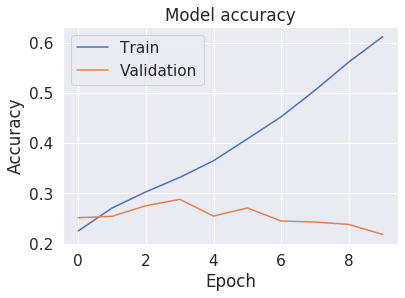

In [151]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Plot training & validation loss values

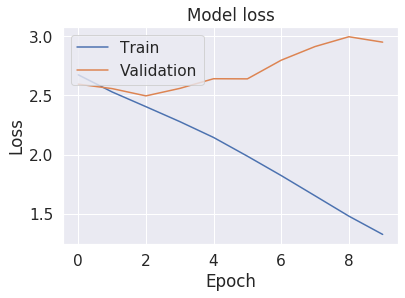

In [152]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Confusion matrix

Computing the confusion matrix

In [0]:
from sklearn.metrics import confusion_matrix

In [0]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

Visualization

In [0]:
import matplotlib.pyplot as plt

In [0]:
# classes = ['❤','😍','😂','💕','🔥','😊','😎','✨','💙','😘','📷','🇺🇸','☀','💜','😉','💯','😁','🎄','📸','😜'] # Plotting emojis is not currently suppoter in matplotlib
classes = range(1,21)

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Plotting the confusion matrix

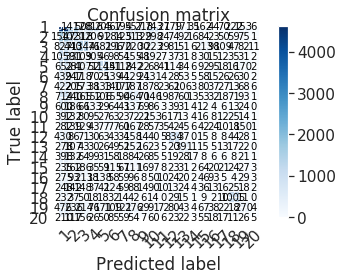

In [131]:
plot_confusion_matrix(y_true, y_pred, classes=classes, normalize=False,
                      title='Confusion matrix')

In [0]:
# Temporary
# cm_norm = [[int(num) for num in row.split(',')] for row in '4609,1412,508,816,205,467,194,557,218,743,27,179,171,35,162,44,70,222,153,6\n1547,1021,318,206,91,284,125,313,129,298,24,74,92,16,84,23,50,59,75,1\n827,440,1344,76,181,296,170,220,30,223,29,81,51,6,213,98,109,47,82,11\n1059,331,109,305,46,98,54,155,48,192,7,37,31,8,30,15,12,35,31,2\n652,281,407,52,1145,141,118,242,22,68,41,114,34,6,92,95,18,16,170,2\n439,247,118,70,25,139,44,129,24,131,4,28,53,5,58,15,26,26,30,2\n422,205,173,38,133,140,177,187,18,78,23,62,106,3,80,37,27,13,68,6\n714,240,165,152,106,155,90,464,70,146,19,87,60,13,53,32,18,71,93,1\n600,186,66,133,29,64,43,137,69,86,3,39,31,4,12,4,6,13,24,0\n392,132,80,95,27,63,23,72,22,153,6,17,13,4,16,8,12,25,14,1\n282,139,129,43,77,77,60,167,28,57,35,42,45,6,42,24,10,18,150,1\n430,86,71,30,63,43,34,158,14,40,5,834,37,0,15,8,8,44,28,1\n278,107,43,30,26,49,52,152,16,23,5,20,391,1,15,5,13,17,22,0\n398,132,64,99,31,58,18,84,26,85,5,19,28,17,8,6,6,8,21,1\n235,162,186,35,59,115,67,111,16,97,8,23,31,2,64,20,21,24,27,3\n275,93,213,18,138,58,59,96,8,50,10,24,20,2,46,93,5,4,29,3\n248,142,148,37,42,124,59,88,14,90,10,13,24,4,36,13,16,25,18,2\n232,37,50,18,18,32,14,42,6,14,0,29,15,1,9,2,10,1005,11,0\n476,236,214,76,171,109,121,276,29,91,72,80,43,4,67,38,22,18,270,4\n210,117,156,26,50,85,59,54,7,60,6,23,22,3,55,18,17,11,26,5'.split('\n')]

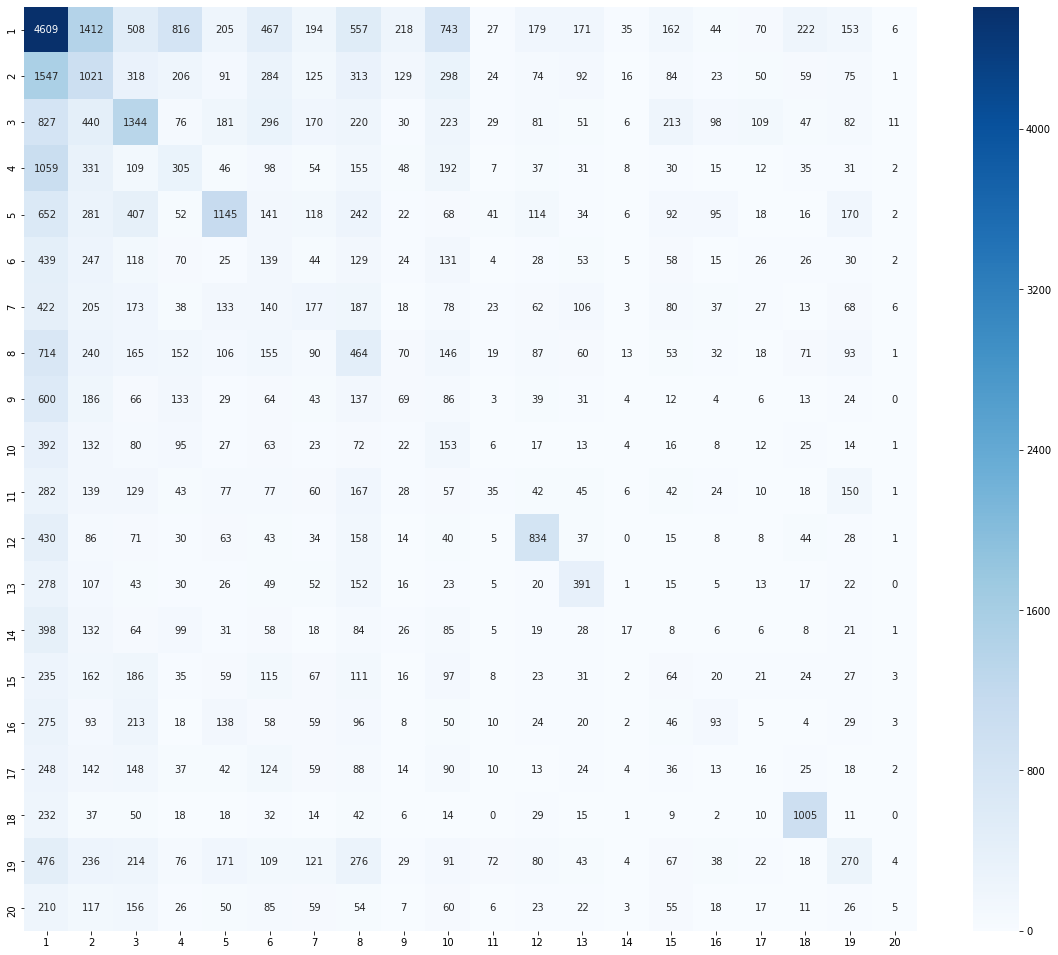

In [30]:
!pip install matplotlib==3.1.0 # to resolve a bug with the current version of matplotlib
import matplotlib.pyplot as plt
import seaborn as sn

df_cm = pd.DataFrame(cm_norm, index = range(1,21),
                  columns = range(1,21))
fgr = plt.figure(figsize = (20,17))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')

Saving the plot as an image

In [0]:
fgr.savefig('confusion_matrix.png')

# Prediction

In [0]:
tweet = "RuPaul's Drag Race bingo fun. Drag Queens be SEXY! #rupaulsdragrace @user abwyman #la…"
label = 9

tokens = tokenizer.texts_to_sequences([tweet])
x = pad_sequences(tokens, padding='post', maxlen=maxlen)

y = np_utils.to_categorical([label], 20)

print(x[0])
print(y)

[    1  2927  1271  6326    29  2927  1925   507   817  6803 24953     1
     1     0     0     0     0     0     0     0     0     0     0     0]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [0]:
prediction = model.predict(x)

print(range(1,21)[np.argmax(prediction[0])])

2


# Saving the model

In [0]:
model.save('/content/drive/My Drive/Projects/Premoji/lstm.h5')